# Data analysis and prediction for laLiga
### The objective of this notebook is practice. The data was taken from Kaggle, just click the link below if you want to check some information related to the dataset or if you want to download it from the website.
### [click here](https://www.kaggle.com/alvarob96/laliga_2018-19_season_player_stats/version/5)

### In general, the dataset shows all the data about players in LaLiga, like the teams each one belongs to, how many matches they played, their goals and stuff like that.
### So, starting with the basic, let's import the libraries we need to work.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Next we are going to read the file that contains all the information, and separate it in different dataframes for future work. The division is going to be done for every position in the game.

In [2]:
data = pd.read_csv("laliga_player_stats_english.csv")

all_columns = data.columns.values.tolist()

data_gk = data[data['Position']=='Goalkeeper']
data_def = data[data['Position']=='Defender']
data_mid = data[data['Position']=='Midfielder']
data_for = data[data['Position']=='Forward']

### Now we are going to see how many players are for every position on the field: Goalkeeper, Defender, Midfielder and Forward. An Histogram should work fine for this.

Text(0.5, 1.0, 'Number of players for position')

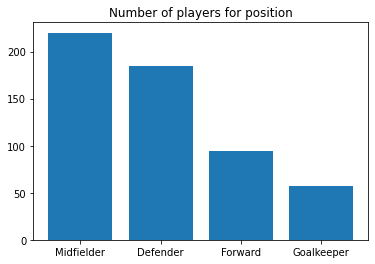

In [3]:
valueC = dict(data['Position'].value_counts())
keysPosition = list(valueC.keys())
valuesPosition = list(valueC.values())

plt.bar(x=keysPosition,height=valuesPosition)
plt.title('Number of players for position')

### As you can see, there are much more defenders and midfielders than goalkeepers and forwards, but that is for the entire database. 
### Now let's see how they are distributed in the teams. A stacked barplot is used for this task.

Text(0.5, 1.0, 'Number of players for team')

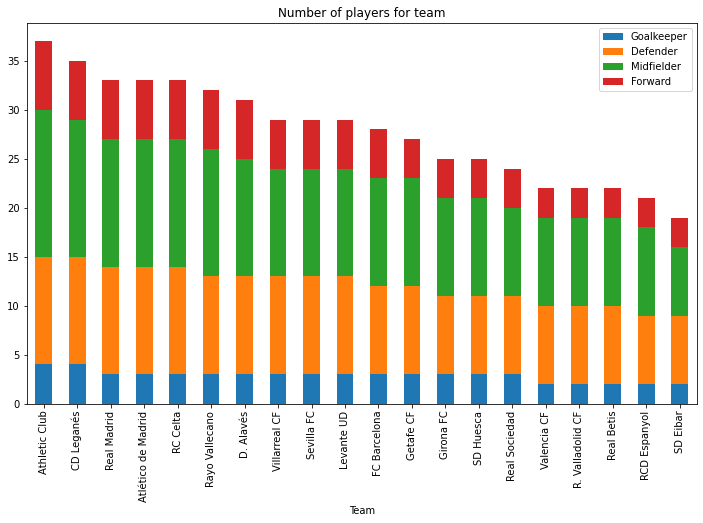

In [4]:
vc1 = dict(data_gk['Team'].value_counts())
keys1 = list(vc1.keys())
values1 = list(vc1.values())

vc2 = dict(data_def['Team'].value_counts())
values2 = list(vc2.values())

vc3 = dict(data_mid['Team'].value_counts())
values3 = list(vc3.values())

vc4 = dict(data_for['Team'].value_counts())
values4 = list(vc4.values())

total = pd.DataFrame()
total['Team'] = keys1
total['Goalkeeper'] = values1
total['Defender'] = values2
total['Midfielder'] = values3
total['Forward'] = values4

total.plot(x='Team', kind='bar',stacked=True,figsize=(12,7))
plt.title('Number of players for team')

### It seems that besides some teams have more players than others, the proportion is kinda the same. 
### The same pattern repeats here, in every team there are more defenders and midfielders than goalkeepers and forwards.

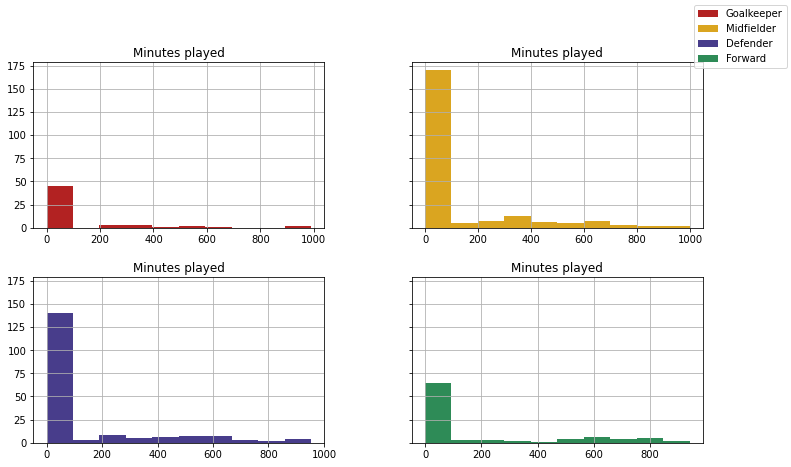

In [5]:
fig, axs = plt.subplots(2,2,figsize=(12,7),sharey=True)
data_gk.hist('Minutes played',ax=axs[0][0],color='firebrick',label='Goalkeeper')
data_def.hist('Minutes played',ax=axs[1][0],color='darkslateblue',label='Defender')
data_mid.hist('Minutes played',ax=axs[0][1],color='goldenrod',label='Midfielder')
data_for.hist('Minutes played',ax=axs[1][1],color='seagreen',label='Forward')

fig.legend(loc='upper right')

### And now talking about how much time they spend on the field, is noticed that depite being one position different to another, they keep the same proportion about time spended in the ground. Midfielder and defender have higher bars because their position have more players, compared to the other ones.

### But if we want to see more differences about stadistic between the positions, is recommended to use a boxplot, like the one below.


Text(0.5, 1.0, 'Distribution of Minutes played for every Position')

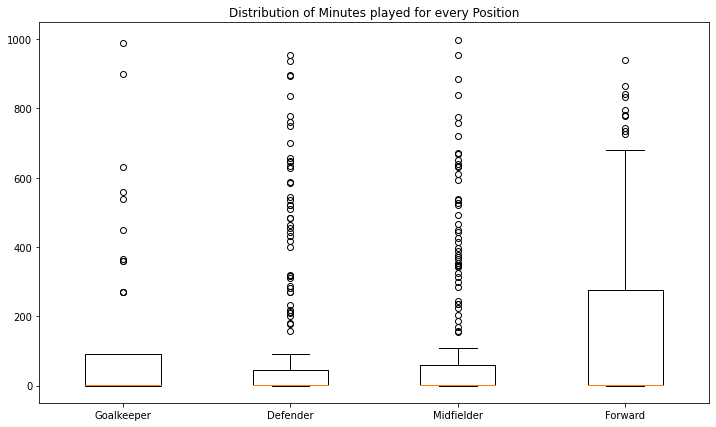

In [6]:
fig2, ax2 = plt.subplots(figsize=(12,7))
info = [data_gk['Minutes played'],data_def['Minutes played'],data_mid['Minutes played'],data_for['Minutes played']]
labels = ['Goalkeeper','Defender','Midfielder','Forward']
ax2.boxplot(info,labels = labels)
ax2.set_title('Distribution of Minutes played for every Position')

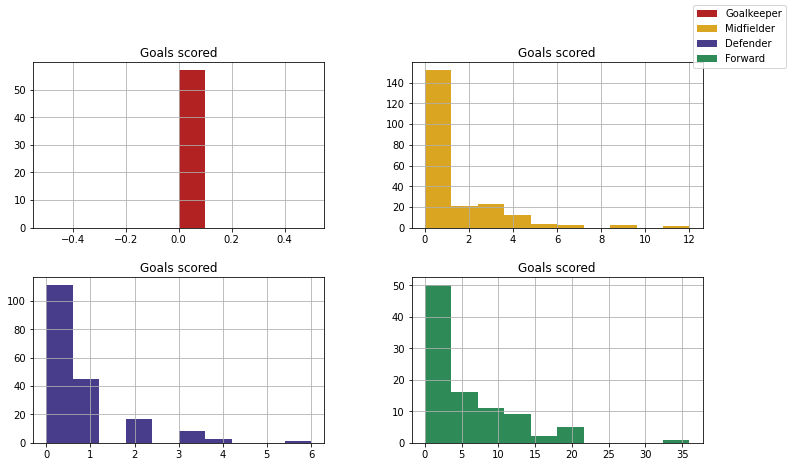

In [7]:
fig2, axs2 = plt.subplots(2,2,figsize=(12,7))
data_gk.hist('Goals scored',ax=axs2[0][0],color='firebrick',label='Goalkeeper')
data_def.hist('Goals scored',ax=axs2[1][0],color='darkslateblue',label='Defender')
data_mid.hist('Goals scored',ax=axs2[0][1],color='goldenrod',label='Midfielder')
data_for.hist('Goals scored',ax=axs2[1][1],color='seagreen',label='Forward')

fig2.legend(loc='upper right')

### Without being a surprise, forwards do more goals in general, while goalkeepers do none.

Text(0.5, 1.0, 'Distribution of Yellow Cards for every Position')

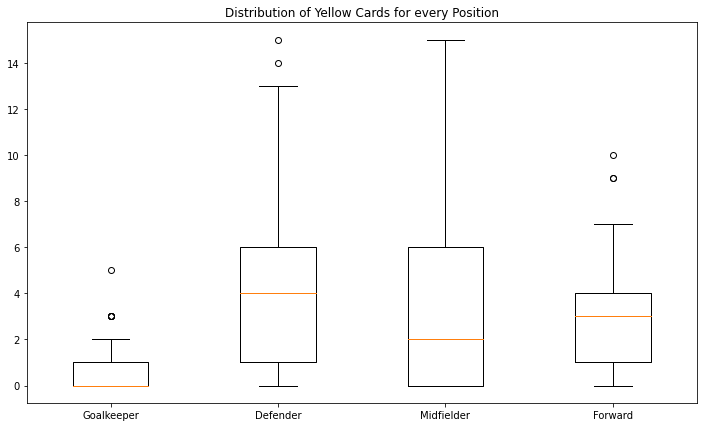

In [8]:
fig2, ax2 = plt.subplots(figsize=(12,7))
info = [data_gk['Yellow Cards'],data_def['Yellow Cards'],data_mid['Yellow Cards'],data_for['Yellow Cards']]
labels = ['Goalkeeper','Defender','Midfielder','Forward']
ax2.boxplot(info,labels = labels)
ax2.set_title('Distribution of Yellow Cards for every Position')

### In this boxplot you can appreciate that the ones who play at the center of the field get more yellow cards in general, but the defenders have the highest average. And again, is no surprise that goalkeepers have the lowest average of getting one.

### Now it's time to clean the entire data and change all to numbers so the models can work them. To start we are going to change al the percentage objects to float, for that we must delete the "%" and then cast to float and divide it by 100.

In [9]:
def percentage_to_float(x):
    x = x.replace(',','.')
    return float(x.strip('%'))/100

data['Percentage of games played'] = data['Percentage of games played'].apply(percentage_to_float)
data['Percentage of full games played'] = data['Percentage of full games played'].apply(percentage_to_float)
data['Percentage of games started'] = data['Percentage of games started'].apply(percentage_to_float)
data['Percentage of games where substituted'] = data['Percentage of games where substituted'].apply(percentage_to_float)


In [10]:
dictionary = {
    'Position':{
        'Goalkeeper':0,
        'Defender':1,
        'Midfielder':2,
        'Forward':3
    }
}
data.replace(dictionary,inplace=True)

### Now we are gonna proceed with filling the null data. One way to do that is replacing the void with the mean. This is how it should look.

In [11]:
data['Shirt number'].describe()

count    526.000000
mean      15.688213
std       10.143810
min        1.000000
25%        7.250000
50%       15.000000
75%       22.000000
max       57.000000
Name: Shirt number, dtype: float64

In [12]:
data['Shirt number'].fillna(15,inplace=True)

### Now we are finally ready to separate the dataset into X and Y. With all the info we have, it should be easy to predict every player's position, so that column is going to be our Y, the rest of the data will be save as X.

In [13]:
y_name = ['Position']
not_wanted = ['Position','Name','Team']
X_name = [x for x in all_columns if x not in not_wanted]
X = pd.DataFrame(data[X_name])
y = pd.DataFrame(data[y_name])


### Our first try is going to be a unsupervised model, so the first choice is Kmeans.

In [14]:
pca = PCA(n_components=2)
reduced = pd.DataFrame(pca.fit_transform(X))

In [15]:
kmeans = KMeans(n_clusters=4,
                n_init=4,
                init='random',
                tol=1e-5, 
                random_state=170)
kmeans.fit(reduced)
predicted = kmeans.predict(reduced)

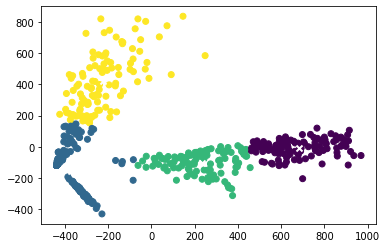

In [16]:
plt.scatter(reduced.iloc[:,0], reduced.iloc[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], 
            kmeans.cluster_centers_[:,1], 
            c='w', marker='x', linewidths=2)

In [17]:
print(classification_report(y,predicted))

              precision    recall  f1-score   support

           0       0.02      0.04      0.02        57
           1       0.30      0.36      0.33       185
           2       0.27      0.14      0.18       220
           3       0.21      0.24      0.23        94

    accuracy                           0.22       556
   macro avg       0.20      0.19      0.19       556
weighted avg       0.24      0.22      0.22       556



### As you can see, it isn't very accurate, but it could happen for severals reansons, maybe the parameters weren't optimal or the model doesn't work well in this case. For our second try we are going to use some Supervised models. The first step for that is to separate the X and y into 'test' and 'train'.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [19]:
modelNB = GaussianNB()
lr = LogisticRegression()
kn = KNeighborsClassifier()
tree = DecisionTreeClassifier()
rfc = RandomForestClassifier()

models = []
models.append(('LR', lr))
models.append(('KNN', kn))
models.append(('DTC', tree))
models.append(('NB', modelNB))
models.append(('RFC',rfc))

### Let's see how accurate these models, to get that info is recommendable to use k-fold cross validation.

In [20]:
results_c = []
names_c = []
seed = 7
for name, model in models:
    
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)    
    
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')    
    results_c.append(cv_results)
    names_c.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.769628 (0.061747)
KNN: 0.599826 (0.046557)
DTC: 0.659350 (0.074344)
NB: 0.570499 (0.103368)
RFC: 0.743496 (0.050620)


### It seems the logistic regression works good in this case. Now let's see what the classificacion report shows.

In [21]:
lr.fit(X_train,y_train)
lr_predicted = lr.predict(X_test)
print(classification_report(y_test,lr_predicted))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        14
           1       0.98      0.92      0.95        49
           2       0.75      0.90      0.82        52
           3       0.81      0.71      0.76        24

    accuracy                           0.85       139
   macro avg       0.88      0.79      0.83       139
weighted avg       0.86      0.85      0.85       139



### it is noticeable when a player belongs to one position or another, because the contribution done for them is different for every kind of occupation in the field, and that is what makes them a team.
### And for the models, everyone of them works with almost every dataset, but the efficiency differs in every case. So if you don't a good result, keep trying, maybe the parameters are wrong or the algorythm is not optimal.